Podklady pro články Anety Martínkové na iROZHLAS.cz v prosinci 2023.

In [170]:
import os
import json
import pandas as pd

In [171]:
from src.tabulka import tabulka
from src.graf import graf

In [172]:
df = pd.read_csv(os.path.join("data","CZ_RADIO_TOP_100_tydenni.csv"))
wikid = pd.read_json(os.path.join("wikidata","wikidata.json"))
df = df.merge(wikid, on="interpret_hlavni", how="outer")
stream = pd.read_csv(os.path.join("data","CZ_SINGLES_DIGITAL_TOP_100_tydenni.csv"))
stream = stream.merge(wikid, on="interpret_hlavni", how="outer")

## Poslední týden v žebříčku bez…

In [173]:
vsechnytydny = [x for x in df['week'].drop_duplicates().to_list() if len(str(x)) == 7]

In [174]:
def kdynaposledne(x):
    pracovni = df[df['interpret_hlavni'] == x].groupby('week')['pozice'].min()
    pracovni = pracovni.reindex(vsechnytydny, fill_value=101).sort_index()
    return pracovni[pracovni > 100].tail(1).index[0]

In [175]:
df = pd.read_csv(os.path.join("data","CZ_RADIO_TOP_100_tydenni.csv"))
wikid = pd.read_json(os.path.join("wikidata","wikidata.json"))
df = df.merge(wikid, on="interpret_hlavni", how="outer")
df = df.sort_values(by='week')

In [176]:
dominatori = df.groupby('interpret_hlavni').size().nlargest(100).index.to_list()

In [177]:
doms = {}
for x in dominatori:
    doms[x] = kdynaposledne(x)

In [178]:
pd.DataFrame(pd.Series(doms).sort_values().head(5)).reset_index().rename(columns = {0 : 'Poslední týden mimo top 100'})

,index,Poslední týden mimo top 100
0,Chinaski,2016-52
1,Mirai,2017-04
2,Kryštof,2017-21
3,Miley Cyrus,2020-39
4,Jelen,2020-43


In [179]:
tabulka(pd.DataFrame(pd.Series(doms).sort_values().head(5)).reset_index().rename(columns = {"index": "Interpreti", 0 : 'Poslední týden mimo top 100'}), titulek="Nejdelší aktuální hitparádové šňůry")

'<table class="dataframe table table--responsive table--w100p table--striped-red table--plain"><caption>Nejdelší aktuální hitparádové šňůry</caption><thead><tr style="text-align: right;"><th class="text-nowrap">Interpreti</th><th class="text-nowrap">Poslední týden mimo top 100</th></tr></thead><tbody class="text-sm"><tr><td>Chinaski</td><td>2016-52</td></tr><tr><td>Mirai</td><td>2017-04</td></tr><tr><td>Kryštof</td><td>2017-21</td></tr><tr><td>Miley Cyrus</td><td>2020-39</td></tr><tr><td>Jelen</td><td>2020-43</td></tr></tbody></table>'

## Jak se točí rádia x stream

In [180]:
df2 = df.copy()

In [181]:
stream = stream[stream['rok'] >= 2015]
df2 = df2[df2['rok'] >= 2015]

In [182]:
stream_novinky = pd.DataFrame(stream.groupby('interpret_hlavni')['rok'].min()).reset_index()

In [183]:
radio_novinky = pd.DataFrame(df2.groupby('interpret_hlavni')['rok'].min()).reset_index()

In [184]:
stream_novinky.groupby('rok')['interpret_hlavni'].nunique().mean()

96.0

In [185]:
radio_novinky.groupby('rok')['interpret_hlavni'].nunique().mean()

89.88888888888889

## Stáří interpretů a kapel

In [186]:
wikid.columns

Index(['interpret_hlavni', 'id', 'stazeno', 'nazev_wiki', 'popis_en',
       'popis_cs', 'velikost', 'zanry', 'datum_narozeni', 'datum_umrti',
       'zacatek_pusobeni', 'konec_pusobeni', 'zalozeni', 'zanik', 'gender',
       'misto_puvodu', 'zeme_puvodu', 'obcanstvi', 'etnicita', 'hlas',
       'nastroje', 'oceneni', 'nabozenstvi', 'orientace', 'spotify_id',
       'spotify_odberatele'],
      dtype='object')

In [187]:
wikid[['interpret_hlavni','zalozeni','zacatek_pusobeni']].dropna()

,interpret_hlavni,zalozeni,zacatek_pusobeni
0,'N Sync,1995.0,1995.0
5,3Oh!3,2004.0,2004.0
6,5 Seconds Of Summer,2011.0,2011.0
13,A Great Big World,2011.0,2011.0
18,ACDC,1973.0,1973.0
...,...,...,...
1570,Ylvis,2000.0,2000.0
1572,Yolanda Be Cool,2009.0,2009.0
1573,Young Rising Sons,2010.0,2010.0
1580,Zac Brown Band,2000.0,2002.0


In [188]:
def vek(row):
    try:
        v = row['rok'] - row['datum_narozeni']
    except:
        v = None 
    return v

In [189]:
def delka_kariery(row):
    try:
        kariera = row['rok'] - row['zacatek_pusobeni']
    except:
        kariera = None
    return kariera

In [190]:
def po_rozpadu(row):
    try:
        pr = row['rok'] - row['konec_pusobeni']
        if pr > 0:
            return pr
        else:
            return None
    except:
        return None

In [191]:
def po_smrti(row):
    try:
        ps = row['rok'] - row['datum_umrti']
        if ps > 0:
            return ps
        else:
            return None
    except:
        return None

In [192]:
def dopln_stari(frame):
    frame = frame.copy()
    frame['vek'] = frame.apply(vek, axis=1)
    frame['delka_kariery'] = frame.apply(delka_kariery, axis=1)
    frame['po_rozpadu'] = frame.apply(po_smrti, axis=1)
    frame['po_smrti'] = frame.apply(po_smrti, axis=1)
    return frame

In [193]:
df = dopln_stari(df)

In [194]:
stream = dopln_stari(stream)

<Axes: xlabel='rok'>

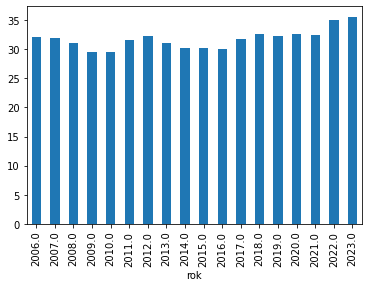

In [195]:
df.groupby('rok')['vek'].mean().plot.bar()

In [196]:
df.groupby('interpret_hlavni')['po_rozpadu'].max().nlargest(50)

interpret_hlavni
John Lennon               42.0
Kamakawiwo´ Ole Israel    16.0
Thomas Gold               16.0
Melanie Thornton          11.0
Notorious B.I.G.           9.0
Michael Jackson            6.0
Karel Gott                 4.0
Avicii                     2.0
David Stypka               2.0
Lil Peep                   2.0
Miro Žbirka                2.0
Petr Muk                   1.0
'N Sync                    NaN
- Universal Music          NaN
2 Chainz                   NaN
2 Pac                      NaN
21 Savage                  NaN
24Kgoldn                   NaN
2Choice                    NaN
2Kbaby                     NaN
3Oh!3                      NaN
5 Seconds Of Summer        NaN
50 Cent                    NaN
5Angels                    NaN
6Ix9Ine                    NaN
7 Ladies                   NaN
99 Souls                   NaN
A Boogie Wit Da Hoodie     NaN
A Fine Frenzy              NaN
A Great Big World          NaN
A$Ap Ferg                  NaN
A$Ap Rocky            

In [197]:
df.groupby('interpret_hlavni')['po_smrti'].max().nlargest(50)

interpret_hlavni
John Lennon               42.0
Kamakawiwo´ Ole Israel    16.0
Thomas Gold               16.0
Melanie Thornton          11.0
Notorious B.I.G.           9.0
Michael Jackson            6.0
Karel Gott                 4.0
Avicii                     2.0
David Stypka               2.0
Lil Peep                   2.0
Miro Žbirka                2.0
Petr Muk                   1.0
'N Sync                    NaN
- Universal Music          NaN
2 Chainz                   NaN
2 Pac                      NaN
21 Savage                  NaN
24Kgoldn                   NaN
2Choice                    NaN
2Kbaby                     NaN
3Oh!3                      NaN
5 Seconds Of Summer        NaN
50 Cent                    NaN
5Angels                    NaN
6Ix9Ine                    NaN
7 Ladies                   NaN
99 Souls                   NaN
A Boogie Wit Da Hoodie     NaN
A Fine Frenzy              NaN
A Great Big World          NaN
A$Ap Ferg                  NaN
A$Ap Rocky            

In [198]:
stream.groupby('interpret_hlavni')['po_smrti'].max().nlargest(50)

interpret_hlavni
John Lennon               42.0
Bing Crosby               41.0
Burl Ives                 27.0
Dean Martin               27.0
Nico                      27.0
Bobby Helms               25.0
Frank Sinatra             24.0
Steve Lacy                18.0
Perry Como                17.0
Thomas Gold               13.0
Cann                      12.0
Andy Williams             10.0
Iveta Bartošová            8.0
Lil Peep                   6.0
Avicii                     5.0
Xxxtentacion               5.0
Karel Gott                 4.0
Juice Wrld                 2.0
Mac Miller                 2.0
Coolio                     1.0
Pop Smoke                  1.0
- Universal Music          NaN
21 Savage                  NaN
24Kgoldn                   NaN
5 Seconds Of Summer        NaN
58G                        NaN
6Ix9Ine                    NaN
A Boogie Wit Da Hoodie     NaN
A$Ap Ferg                  NaN
A$Ap Rocky                 NaN
A-Trak                     NaN
Aaron Carter          

In [199]:
stream.groupby('interpret_hlavni')['vek'].max().nlargest(50)

interpret_hlavni
Bing Crosby            115.0
Burl Ives              113.0
Frank Sinatra          107.0
Perry Como             106.0
Dean Martin            105.0
Thomas Gold             97.0
Andy Williams           95.0
Bobby Helms             89.0
Steve Lacy              88.0
John Williams           85.0
Karel Gott              84.0
John Lennon             82.0
Leonard Cohen           82.0
Paul Mccartney          80.0
Václav Neckář           80.0
Brenda Lee              79.0
Cann                    77.0
José Feliciano          77.0
Nico                    77.0
Elton John              76.0
Hana Zagorová           76.0
Zagorová                76.0
Paul Simon              74.0
Shakin' Stevens         74.0
Kojo                    70.0
Van Morrison            70.0
David Bowie             69.0
Miro Žbirka             69.0
Chris Rea               67.0
Matthew Wilder          67.0
Věra Špinarová          66.0
James Newton Howard     64.0
Annie Lennox            61.0
Manu Chao               61

In [200]:
stream.groupby('interpret_hlavni')['delka_kariery'].max().nlargest(50)

interpret_hlavni
Bing Crosby              92.0
Burl Ives                87.0
Frank Sinatra            87.0
Perry Como               86.0
Andy Williams            84.0
Dean Martin              82.0
Brenda Lee               72.0
Bobby Helms              67.0
John Lennon              66.0
John Williams            65.0
Karel Gott               65.0
Paul Mccartney           65.0
Beatles                  63.0
The Ronettes             63.0
Elton John               61.0
Nico                     61.0
Leonard Cohen            60.0
Hana Zagorová            59.0
Zagorová                 59.0
José Feliciano           58.0
Paul Simon               58.0
Van Morrison             57.0
Václav Neckář            57.0
Ricchi E Poveri          56.0
Shakin' Stevens          54.0
Aerosmith                53.0
David Bowie              52.0
Edison Lighthouse        52.0
Miro Žbirka              52.0
Věra Špinarová           50.0
Queen                    49.0
Matthew Wilder           48.0
Wham!                  

In [201]:
df.groupby('interpret_hlavni')['delka_kariery'].max().nlargest(50)

interpret_hlavni
Tony Bennett              69.0
John Lennon               66.0
Karel Gott                65.0
Elton John                61.0
Hana Zagorová             56.0
Václav Neckář             56.0
Miro Žbirka               54.0
Queen                     52.0
Michael Jackson           51.0
Paul Mccartney            50.0
Zagorová                  50.0
Elán                      49.0
Kenny Rogers              48.0
Joe Cocker                47.0
Shakin' Stevens           47.0
Khaled                    46.0
Michal David              44.0
Depeche Mode              43.0
Helena Vondráčková        43.0
David Koller              42.0
Phil Collins              42.0
U2                        42.0
Wham!                     42.0
Citron                    41.0
Fred Roberts              41.0
Janek Ledecký             41.0
Luis Fonsi                41.0
James Newton Howard       40.0
Kabát                     40.0
Petr Kotvald              40.0
Red Hot Chili Peppers     40.0
Santana               

In [202]:
df.groupby('interpret_hlavni')['po_rozpadu'].max().nlargest(50)

interpret_hlavni
John Lennon               42.0
Kamakawiwo´ Ole Israel    16.0
Thomas Gold               16.0
Melanie Thornton          11.0
Notorious B.I.G.           9.0
Michael Jackson            6.0
Karel Gott                 4.0
Avicii                     2.0
David Stypka               2.0
Lil Peep                   2.0
Miro Žbirka                2.0
Petr Muk                   1.0
'N Sync                    NaN
- Universal Music          NaN
2 Chainz                   NaN
2 Pac                      NaN
21 Savage                  NaN
24Kgoldn                   NaN
2Choice                    NaN
2Kbaby                     NaN
3Oh!3                      NaN
5 Seconds Of Summer        NaN
50 Cent                    NaN
5Angels                    NaN
6Ix9Ine                    NaN
7 Ladies                   NaN
99 Souls                   NaN
A Boogie Wit Da Hoodie     NaN
A Fine Frenzy              NaN
A Great Big World          NaN
A$Ap Ferg                  NaN
A$Ap Rocky            

In [203]:
df['delka_kariery'].sample(50)

34012     NaN
45981     NaN
40315     9.0
14020    12.0
30403    20.0
83325     6.0
78715    12.0
21911    24.0
3916     20.0
22278    33.0
87052     2.0
62803     8.0
11079    18.0
82194     NaN
17908    24.0
26991    10.0
32040    12.0
30590    25.0
3986     21.0
66101    22.0
27547    23.0
77874    20.0
60433    10.0
14623     9.0
82466     NaN
74014     3.0
76634     7.0
11410    14.0
88065     7.0
22388    36.0
23291    21.0
69524     NaN
33149     6.0
38616    10.0
32800     7.0
54121     9.0
56864     4.0
18992     1.0
61204     7.0
65758     NaN
25118     7.0
45       27.0
88011     4.0
56859     4.0
64328     5.0
58912     NaN
13173    21.0
59329     8.0
69467     NaN
50272     NaN
Name: delka_kariery, dtype: float64

In [204]:
stream.groupby

<bound method DataFrame.groupby of                             hitparada     rok  tyden     week  pozice  \
41     CZ - SINGLES DIGITAL - TOP 100  2015.0    1.0  2015-01    38.0   
42     CZ - SINGLES DIGITAL - TOP 100  2015.0    2.0  2015-02    56.0   
43     CZ - SINGLES DIGITAL - TOP 100  2015.0    3.0  2015-03    66.0   
44     CZ - SINGLES DIGITAL - TOP 100  2015.0    4.0  2015-04    67.0   
45     CZ - SINGLES DIGITAL - TOP 100  2015.0    5.0  2015-05    81.0   
...                               ...     ...    ...      ...     ...   
48495  CZ - SINGLES DIGITAL - TOP 100  2023.0   45.0  2023-45   100.0   
48496  CZ - SINGLES DIGITAL - TOP 100  2023.0   46.0  2023-46    96.0   
48497  CZ - SINGLES DIGITAL - TOP 100  2023.0   47.0  2023-47    57.0   
48498  CZ - SINGLES DIGITAL - TOP 100  2023.0   46.0  2023-46    60.0   
48499  CZ - SINGLES DIGITAL - TOP 100  2023.0   47.0  2023-47    11.0   

                                  track            interpret  \
41                      

<Axes: xlabel='rok'>

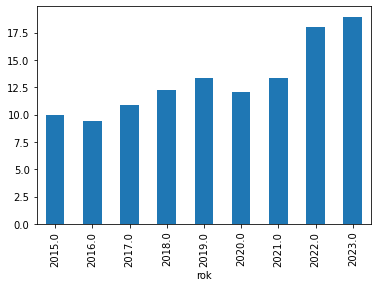

In [205]:
stream.groupby('rok')['delka_kariery'].mean().plot.bar()

<Axes: xlabel='rok'>

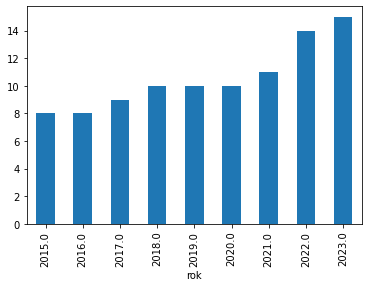

In [206]:
stream.groupby('rok')['delka_kariery'].median().plot.bar()

In [209]:
len(df[(df['rok'] == 2015) & (df['delka_kariery'].isnull())]) / len(df[df['rok'] == 2015])

0.1676923076923077

In [210]:
len(df[(df['rok'] == 2023) & (df['delka_kariery'].isnull())]) / len(df[df['rok'] == 2023])

0.29595744680851066

In [208]:
len(stream[(stream['rok'] == 2015) & (stream['delka_kariery'].isnull())]) / len(stream[stream['rok'] == 2015])

0.06865384615384615

In [207]:
len(stream[(stream['rok'] == 2023) & (stream['delka_kariery'].isnull())]) / len(stream[stream['rok'] == 2023])

0.5127659574468085